In [1]:
import os

import torch
import cv2 as cv
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

from pathlib import Path
from torchvision import models

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# from torch.cuda import amp
from tqdm.autonotebook import tqdm
from torch.optim import lr_scheduler
from torchvision import transforms
from torchmetrics import ConfusionMatrix
from torchmetrics.functional import f1_score, accuracy
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

# Создание датасета для обучения и тестирования

In [2]:
class CreateDataset(Dataset):
    """
    Класс загрузки dataset

    :list_classes: список классов.
    :img_path_list: список путей до изображений.
    :transform: список преобразовай dataset.
    :img_list: список изображений.
    """

    def __init__(self, data_frame, transform: transforms.Compose = None):
        
        self.list_classes = data_frame['labels'].to_list()
        self.img_path_list = data_frame['paths'].to_list()
        self.transform = transform
        self.img_list = []

        for path in self.img_path_list:
            img = self.__get_img_by_path(path)
            self.img_list.append(img)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        sample = {'image': self.img_list[index],
                  'target':  self.list_classes[index]}
    
        if self.transform:
            sample["image"] = self.transform(self.img_list[index])

        return sample

    @staticmethod
    def __get_img_by_path(img_path):
        """
        Получение картинки по её пути.
        :img_path: путь до картинки
        :return: картинка, состаящая из массива цифр
        """
        # чтобы картинки считывались и с русским путем
        f = open(img_path, "rb");
        chunk = f.read()
        chunk_arr = np.frombuffer(chunk, dtype=np.uint8)
        img = cv.imdecode(chunk_arr, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#         (B, G, R) = cv.split(img)
        img = np.array(img)
        return img

In [3]:
def create_dataloader_test(path_data):
    df = pd.read_csv(path_data)
    data = CreateDataset(df,transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize(size=(224,224))]))
    
    data_dl = DataLoader(data, batch_size=3, shuffle=True)
    
    return data_dl

def create_dataloader_train_valid(path_data):
    df = pd.read_csv(path_data)
    data = CreateDataset(df,
                         transform=transforms.Compose([
                                                        transforms.ToTensor(),
                                                        transforms.RandomRotation(180),
                                                        transforms.Resize(size=(370,370)),
                                                        transforms.RandomCrop(size=(224,224))
                                                      ])
                        )
    
    data_dl = DataLoader(data, batch_size=3, shuffle=True)
    
    return data_dl

In [4]:
train_dl = create_dataloader_train_valid('../data/prepared/train.csv')
valid_dl = create_dataloader_train_valid('../data/prepared/valid.csv')
test_dl = create_dataloader_test('../data/prepared/test.csv')

In [5]:
print('len train ', len(train_dl)*3)
print('len valid ', len(valid_dl)*3)
print('len test ', len(test_dl)*3)

len train  720
len valid  180
len test  102


In [6]:
print('len train_dl ', len(train_dl))
print('len valid_dl ', len(valid_dl))
print('len test_dl ', len(test_dl))

len train_dl  240
len valid_dl  60
len test_dl  34


# Обучение и подсчет метрик на обучение и валидации

In [7]:
class Count_ConfusionMatrix(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.metric_vals = []
        self.confmat = ConfusionMatrix(**kwargs)
    
    def forward(self, preds, target):
        val = self.confmat(preds.cpu(), target.cpu())
        self.metric_vals.append(val)
    
    def get_metric(self):
        return torch.stack(self.metric_vals).sum(dim=0)
    
class Count_F1_score(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.metric_vals = []
        self.num_classes = num_classes
    
    def forward(self, preds, target):
        val = f1_score(preds, target, average='weighted', num_classes=self.num_classes)
        self.metric_vals.append(val)
    
    def get_metric(self):
        return torch.stack(self.metric_vals).mean().item()
    
class Count_Accuracy(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.metric_vals = []
        self.num_classes = num_classes
    
    def forward(self, preds, target):
        val = accuracy(preds, target, average='weighted', num_classes=self.num_classes)
        self.metric_vals.append(val)
    
    def get_metric(self):
        return torch.stack(self.metric_vals).mean().item()

In [19]:
def count_metrics(data_dl, device, model, loss_func, list_metric=[]):
    """
    list_metric_with_test=[Count_F1_score(num_classes=2),
                            Count_Accuracy(num_classes=2),
                            Confusion_Matrix(num_classes=2)]
    
    list_metric_with_valid=[Count_F1_score(num_classes=2),
                            Count_Accuracy(num_classes=2)]
    """
    model.eval()
    metrics_val = []
    loss_sum = 0
    
    with torch.no_grad():
        for target in tqdm(data_dl):
            xb, yb = target['image'].to(device),\
                     target['target'].to(device)
            
            probs = model(xb)
#             print(probs)
            
            loss_sum += loss_func(probs, yb).item()

            _, preds = torch.max(probs, axis=-1)
            
#             print(yb, preds)
            for metric in list_metric:
                metric(preds, yb)
            
    val_loss_valid = (loss_sum / len(data_dl))
    
    
    for metric in list_metric:
        metrics_val.append(metric.get_metric())
        
    metrics_val.append(val_loss_valid) 
    
    return metrics_val

In [9]:
class EarlyStopping:
    """ """
    def __init__(self, patience=15):
        self.best_fitness = 0.0  # f1_score
        self.best_epoch = 0
        self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop
        self.possible_stop = False  # possible stop may occur next epoch

    def __call__(self, epoch, fitness):
        if fitness >= self.best_fitness:  # >= 0 to allow for early zero-fitness stage of training
            self.best_epoch = epoch
            self.best_fitness = fitness
        delta = epoch - self.best_epoch  # epochs without improvement
        self.possible_stop = delta >= (self.patience - 1)  # possible stop may occur next epoch
        stop = delta >= self.patience  # stop training if patience exceeded
        if stop:
            print(f'Stopping training early as no improvement observed in last {self.patience} epochs. '
                        f'Best results observed at epoch {self.best_epoch}, best model saved in folder models.\n')
        return stop

In [10]:
def fit(epochs, model, loss_func, opt,
        train_dl, valid_dl, device,
        name_model = 'model_best_drop',  lr_scale = 0.01):
    
    """
    Обучение модели.

    :param epochs: количество эпох.
    :param model: модель, для обучения
    .
    :param loss_func: функция потерь сети.
    :param opt: функция оптимизации.
    :param train_dl: обучающая выборка.
    :param valid_dl: валиационная выборка.
    :return: массивы с метриками качества обученной модели.
    """
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / train_dl.batch_size), 1)  # accumulate loss before optimizing
    
    lf = lambda x: (1 - x / epochs) * (1.0 - lr_scale) + lr_scale # linear
    scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lf)  # plot_lr_scheduler(optimizer, scheduler, epochs)
    
    train_losses = []
    val_losses = []
    val_accur = []
    val_f1 = []
    best_f1 = 0
    best_acur = 0
    
    date_today = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S').replace(':', '.')
    writer = SummaryWriter(Path('../models/tendorboard/', name_model + '-' + date_today))
    stopper = EarlyStopping()
    
    for epoch in range(epochs):
        print("epoch ", epoch)
        model.train()
        loss_sum = 0
        last_opt_step = 0
        for idx, target in enumerate(tqdm(train_dl)):
            xb, yb = target['image'].to(device),\
                     target['target'].to(device)
            
            pred = model(xb)  # forward
            loss = loss_func(pred, yb)  # loss scaled by batch_size
            loss_sum += loss.item()
            loss.backward()

            if idx - last_opt_step >= accumulate:
                opt.step()
                opt.zero_grad()
                last_opt_step = idx
                
        train_loss = loss_sum / len(train_dl)
        train_losses.append(train_loss)
        print("train_loss: ", train_loss)
        
        scheduler.step()

        f1_score, acur, valid_loss = count_metrics(valid_dl, device,
                                                   model, loss_func, [Count_F1_score(num_classes=2),
                                                                   Count_Accuracy(num_classes=2)])
        print("valid loss: ", valid_loss)
        val_losses.append(valid_loss)

        print("valid accuracies: ", acur)
        val_accur.append(acur)
        
        print("valid f1: ", f1_score)
        val_f1.append(f1_score)
        
        # сохранение лучшей модели
        if val_f1[-1] > best_f1 and acur > best_acur:
            best_f1 = val_f1[-1]
            best_acur = acur
            print('\n save model \n')
            torch.save(model, Path('../models/', name_model + '.pt'))
            
    
         # Tensorboard save loss and metrics
        writer.add_scalars('Loss/loss', {'train':train_loss, 'valid':valid_loss}, epoch)
        writer.add_scalar('Metrics/accuracies', acur, epoch)
        writer.add_scalar('Metrics/f1_score', f1_score, epoch)
    
         # Stop fit
        if (epoch == epochs-1) or stopper(epoch, best_f1):
            # Tensorboard write hyperparam
#             writer.add_hparams(
#                 {'epoch': epoch, 
#                  'lr': model.hyp['l_r'], 
#                 }, # huperparams
#             ) 
            break
    
    writer.close()
    
    return train_losses, val_losses, val_accur, val_f1

In [11]:
def plot_training(train_losses, valid_losses, valid_accuracies):
    """
    Отрисовка графиков после обучения.
    Графики loss-функции на каждой эпохи.
    График точности valid на каждой эпохи.

    :train_losses: значение loss-функции на train каждая эпоха
    :valid_losses: значение loss-функции на valid каждая эпоха
    :valid_accuracies: точность на valid каждая эпоха
    """
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [12]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

In [13]:
loss_fn = nn.CrossEntropyLoss()

# Модели

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 16, 7)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, 1)
        self.bn6 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(2048, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 64)
        self.bn8 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), 2))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = self.bn3(F.max_pool2d(F.relu(self.conv3(x)), 2))
        x = self.bn4(F.max_pool2d(F.relu(self.conv4(x)), 2))
        x = self.bn5(F.max_pool2d(F.relu(self.conv5(x)), 2))
        x = self.bn6(F.max_pool2d(F.relu(self.conv6(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn7(F.relu(self.fc1(x)))
        x = self.bn8(F.relu(self.fc2(x)))
        
        x = F.softmax(self.fc3(x))
        return x

In [17]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses, val_accur, val_f1 = fit(20, model, loss_fn,
                                                      optimizer,
                                                      train_dl, valid_dl,device, 'my_model_cnn_gray_r')

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

C:\Users\89zaz\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train_loss:  0.7008558519184589


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6796678667267163
valid accuracies:  0.5833333730697632
valid f1:  0.5972222685813904

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6540940146893263


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6455943082769712
valid accuracies:  0.6333333849906921
valid f1:  0.6111111640930176

 save model 

epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6503007208307584


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6640778809785843
valid accuracies:  0.6111111640930176
valid f1:  0.6005555987358093
epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6427987745652596


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6380086312691371
valid accuracies:  0.6500000357627869
valid f1:  0.6500000357627869

 save model 

epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6565612114965915


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6447850669423739
valid accuracies:  0.6611111760139465
valid f1:  0.6555556058883667

 save model 

epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6322372857481241


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6407665898402531
valid accuracies:  0.6555556058883667
valid f1:  0.6627779006958008
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6431594253828128


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6366084650158882
valid accuracies:  0.6666666865348816
valid f1:  0.6672223210334778

 save model 

epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6586824938654899


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6357314512133598
valid accuracies:  0.6666666865348816
valid f1:  0.6650000810623169
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6440014091630777


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6299233004450798
valid accuracies:  0.6333333849906921
valid f1:  0.6211112141609192
epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6476500255366167


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6381795729200045
valid accuracies:  0.6722223162651062
valid f1:  0.6733334064483643

 save model 

epoch  10


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.645204417904218


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6280618747075398
valid accuracies:  0.6833333969116211
valid f1:  0.6844445466995239

 save model 

epoch  11


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6417712246378263


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6343010301391284
valid accuracies:  0.6222223043441772
valid f1:  0.6261111497879028
epoch  12


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6410843845456838


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6468952417373657
valid accuracies:  0.6333333849906921
valid f1:  0.6305556297302246
epoch  13


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6363367247084777


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6379458859562874
valid accuracies:  0.638888955116272
valid f1:  0.64000004529953
epoch  14


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6351085045685371


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6400161579251289
valid accuracies:  0.6222223043441772
valid f1:  0.6122223138809204
epoch  15


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6496124375611544


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6203280965487162
valid accuracies:  0.6611111760139465
valid f1:  0.6794445514678955
epoch  16


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6219212129712105


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.614008312424024
valid accuracies:  0.7000000476837158
valid f1:  0.7077777981758118

 save model 

epoch  17


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.627322872603933


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6404444312055906
valid accuracies:  0.638888955116272
valid f1:  0.6194444298744202
epoch  18


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6362318695833286


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.643361467619737
valid accuracies:  0.6444445252418518
valid f1:  0.6344444751739502
epoch  19


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6499785685290893


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6206498439113299
valid accuracies:  0.6777778267860413
valid f1:  0.6877778172492981


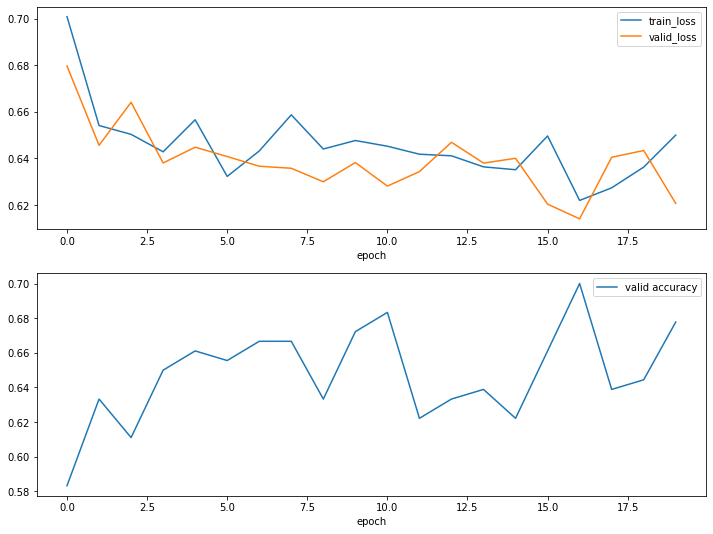

In [18]:
plot_training(train_losses, val_losses, val_accur)

Проверка на тесте

In [50]:
# Path(ROOT, 'models', 'model_best.pt'))
# model = Model().to(device)
model = torch.load('../models/my_model_cnn_gray_r.pt').to(device)
                      
accur, f1_sc, cof_matrix, _ = count_metrics(test_dl, device, model, loss_fn, [Count_F1_score(num_classes=2),
                                                                  Count_Accuracy(num_classes=2),
                                                                  Count_ConfusionMatrix(num_classes=2)])

  0%|          | 0/34 [00:00<?, ?it/s]

C:\Users\89zaz\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([1, 0, 1], device='cuda:0') tensor([1, 0, 1], device='cuda:0')
tensor([0, 0, 1], device='cuda:0') tensor([0, 0, 1], device='cuda:0')
tensor([0, 0, 0], device='cuda:0') tensor([0, 0, 1], device='cuda:0')
tensor([0, 0, 1], device='cuda:0') tensor([0, 0, 0], device='cuda:0')
tensor([0, 0, 0], device='cuda:0') tensor([0, 0, 1], device='cuda:0')
tensor([1, 1, 1], device='cuda:0') tensor([1, 0, 1], device='cuda:0')
tensor([0, 1, 0], device='cuda:0') tensor([0, 0, 0], device='cuda:0')
tensor([0, 1, 0], device='cuda:0') tensor([1, 0, 0], device='cuda:0')
tensor([1, 1, 0], device='cuda:0') tensor([1, 1, 0], device='cuda:0')
tensor([1, 1, 1], device='cuda:0') tensor([1, 0, 1], device='cuda:0')
tensor([1, 1, 0], device='cuda:0') tensor([1, 0, 0], device='cuda:0')
tensor([0, 1, 1], device='cuda:0') tensor([0, 0, 1], device='cuda:0')
tensor([1, 1, 1], device='cuda:0') tensor([0, 1, 0], device='cuda:0')
tensor([1, 1, 0], device='cuda:0') tensor([1, 1, 1], device='cuda:0')
tensor([1, 0, 1], de

In [52]:
cof_matrix

tensor([[37, 11],
        [16, 36]])

In [51]:
print('test auc: ', accur)
print('f1 auc: ', f1_sc)

test auc:  0.751960813999176
f1 auc:  0.7352941036224365


# VGG

In [28]:
model_vgg = models.vgg16(pretrained=True)

In [29]:
for param in model_vgg.features[:22].parameters():
    param.requires_grad = False
    

In [30]:
# Add on classifier
model_vgg.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 2),                   
                      nn.LogSoftmax(dim=1))

model_vgg = model_vgg.to('cuda')
optimizer = optim.Adam(model_vgg.parameters())

In [31]:
train_losses, val_losses, val_accur, val_f1 = fit(10, model_vgg, loss_fn,
                                                      optimizer,
                                                      train_dl, valid_dl,device, 'my_model_cnn_vgg')

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.8121356505706596


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6919719735781352
valid accuracies:  0.5166667103767395
valid f1:  0.5161111950874329

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.7490314284960429


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6990417291720709
valid accuracies:  0.45555558800697327
valid f1:  0.3527778089046478
epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6959516448279222


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6886829266945521
valid accuracies:  0.5444445013999939
valid f1:  0.440555602312088
epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6916570230076711


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6997875074545542
valid accuracies:  0.45555558800697327
valid f1:  0.3527778089046478
epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6928936270376046


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.688690847158432
valid accuracies:  0.4611111581325531
valid f1:  0.3544444441795349
epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6984043914824725


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6895653933286667
valid accuracies:  0.5444445013999939
valid f1:  0.4288889169692993
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6956612785657247


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6937030772368113
valid accuracies:  0.45555561780929565
valid f1:  0.33277779817581177
epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6921479600171249


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.695045797030131
valid accuracies:  0.45555558800697327
valid f1:  0.34111112356185913
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6942342258989811


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6967672765254974
valid accuracies:  0.45555558800697327
valid f1:  0.32777780294418335
epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6930317242940267


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6960591912269593
valid accuracies:  0.45555558800697327
valid f1:  0.34111112356185913


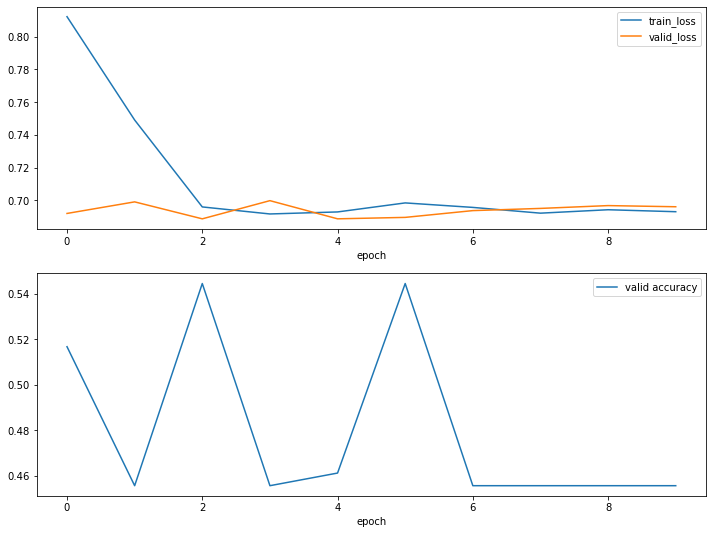

In [32]:
plot_training(train_losses, val_losses, val_accur)

In [15]:
# Path(ROOT, 'models', 'model_best.pt'))
# model = Model().to(device)
model_vgg = torch.load('../models/my_model_cnn_vgg.pt').to(device)
                      
accur, f1_sc, cof_matrix, _ = count_metrics(test_dl, device, model_vgg, loss_fn, [Count_F1_score(num_classes=2),
                                                                  Count_Accuracy(num_classes=2),
                                                                  Count_ConfusionMatrix(num_classes=2)])

  0%|          | 0/34 [00:00<?, ?it/s]

In [16]:
cof_matrix

tensor([[26, 22],
        [27, 25]])

In [17]:
print('test auc: ', accur)
print('f1 auc: ', f1_sc)

test auc:  0.5186275243759155
f1 auc:  0.5196079015731812


## Обучение и тестирование моделей efficientnet 

In [17]:
def model_eff(model):
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier = nn.Sequential(
                      nn.Dropout(p=0.2, inplace=True),
                      nn.Linear(in_features=2048 , out_features=2, bias=True),                   
                      nn.LogSoftmax(dim=1))
    model = model.to('cuda')
    optimizer = optim.Adam(model.parameters())
    
    return model, optimizer

In [ ]:
# просмотр слоев, которые были заморожены
for name_param, param in model_eff.named_parameters():
    if not param.requires_grad:
        print(name_param)

In [14]:
def start_fit_model(model_name, optimizer, epoht, name_save):
    
    
    train_losses, val_losses, val_accur, val_f1 = fit(epoht, model_name,
                                                      loss_fn,
                                                      optimizer,
                                                      train_dl,
                                                      valid_dl,
                                                      device,
                                                      name_save)
    
    plot_training(train_losses, val_losses, val_accur)

In [15]:
def testing_model(name_save):
    
    model = torch.load(f'../models/{name_save}.pt').to(device)
                      
    accur, f1_sc, cof_matrix, _ = count_metrics(test_dl,
                                                device,
                                                model,
                                                loss_fn,
                                                [Count_F1_score(num_classes=2),
                                                Count_Accuracy(num_classes=2),
                                                Count_ConfusionMatrix(num_classes=2)])
    
    print('test auc: ', accur)
    print('test f1: ', f1_sc)
    print('ConfusionMatrix:\n', cof_matrix)

# efficientnet_b0

In [24]:
model_eff_0, optimazer_o = model_eff(models.efficientnet_b0(pretrained=True))

In [38]:
train_losses, val_losses, val_accur, val_f1 = fit(50, model_eff,
                                                      loss_fn,
                                                      optimizer,
                                                      train_dl,
                                                      valid_dl,
                                                      device,
                                                      'model_eff_0')

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.34896784874921044


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.39514453735512994
valid accuracies:  0.8833333849906921
valid f1:  0.8838889002799988

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.24847750586923212


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.45539550598865997
valid accuracies:  0.8333333730697632
valid f1:  0.8327778577804565
epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2111416664343172


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4269167104968801
valid accuracies:  0.8388890027999878
valid f1:  0.8366667032241821
epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2648844705079682


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3568363947793841
valid accuracies:  0.9000000357627869
valid f1:  0.8922223448753357

 save model 

epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.21999448074687583


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.45427231406016894
valid accuracies:  0.8333333730697632
valid f1:  0.8322222828865051
epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2560275693773292


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.45086980299868934
valid accuracies:  0.8500000238418579
valid f1:  0.8472222685813904
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.22886841886599238


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4670228450015808
valid accuracies:  0.8222222924232483
valid f1:  0.8222222924232483
epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2327825365025395


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3860106211466094
valid accuracies:  0.8388890027999878
valid f1:  0.82833331823349
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.21790306120625852


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.468109125783667
valid accuracies:  0.8555556535720825
valid f1:  0.8594444990158081
epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.22728721615082273


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.367971886958306
valid accuracies:  0.8611111640930176
valid f1:  0.867222249507904
epoch  10


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19663065649801864


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4415274763479829
valid accuracies:  0.8555556535720825
valid f1:  0.8638889789581299
epoch  11


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.20932448400514356


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4438831253287693
valid accuracies:  0.8277778625488281
valid f1:  0.8283333778381348
epoch  12


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2357668618526077


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.46814617864244307
valid accuracies:  0.8666667342185974
valid f1:  0.866111159324646
epoch  13


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.22946624425239862


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.43894513793056833
valid accuracies:  0.8277778625488281
valid f1:  0.8194445371627808
epoch  14


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.20418499312363564


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4461785855625446
valid accuracies:  0.8333333730697632
valid f1:  0.8222222924232483
epoch  15


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.20811841449661492


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4659766921230281
valid accuracies:  0.8111111521720886
valid f1:  0.8411111831665039
epoch  16


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2057152134560359


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4541031898348592
valid accuracies:  0.8333333730697632
valid f1:  0.8538889288902283
epoch  17


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2045565237077729


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.47213714277216545
valid accuracies:  0.8333333730697632
valid f1:  0.8283333778381348
epoch  18


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.22839176237951808


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4442399251003129
valid accuracies:  0.8388890027999878
valid f1:  0.8361111283302307
epoch  19


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2105794701143168


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4845587680737177
valid accuracies:  0.8222222924232483
valid f1:  0.8166667222976685
epoch  20


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.23117239655111915


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4049219749557475
valid accuracies:  0.8666667342185974
valid f1:  0.8638889193534851
epoch  21


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.21187265125918203


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4757876578660216
valid accuracies:  0.8388890027999878
valid f1:  0.8450000286102295
epoch  22


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19849854389030952


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4627527198754251
valid accuracies:  0.8500000238418579
valid f1:  0.8500000238418579
epoch  23


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.21976248560337505


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.42045526842121034
valid accuracies:  0.8611111640930176
valid f1:  0.8766666650772095
epoch  24


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.22173179239034652


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4269747285482784
valid accuracies:  0.8222222924232483
valid f1:  0.8238889575004578
epoch  25


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19236834492573204


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4619081528314079
valid accuracies:  0.8500000238418579
valid f1:  0.8477778434753418
epoch  26


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.20721408749717132


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3793128036758086
valid accuracies:  0.888888955116272
valid f1:  0.893333375453949
epoch  27


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.20125468718082024


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4053088205866516
valid accuracies:  0.8444445133209229
valid f1:  0.846666693687439
epoch  28


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.21525637707478987


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4950247621590582
valid accuracies:  0.8222222924232483
valid f1:  0.8316667079925537
epoch  29


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2095807647293744


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.45706988606446736
valid accuracies:  0.8444445133209229
valid f1:  0.8650000691413879
epoch  30


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.177192755403424


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3983342443515236
valid accuracies:  0.8666667342185974
valid f1:  0.8583333492279053
epoch  31


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.20261226712027564


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4295319568986694
valid accuracies:  0.8555556535720825
valid f1:  0.8666667342185974
epoch  32


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.20971585137206905


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5543003329822871
valid accuracies:  0.8000000715255737
valid f1:  0.8016667366027832
epoch  33


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19734011470039453


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.41923462660827987
valid accuracies:  0.8555556535720825
valid f1:  0.8550000190734863
epoch  34


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.1810556041280506


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5326323269749992
valid accuracies:  0.8500000238418579
valid f1:  0.8550000190734863
epoch  35


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19794048087787813


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5565375576183821
valid accuracies:  0.8277778625488281
valid f1:  0.8488889336585999
epoch  36


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19901948496165764


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3904675724528109
valid accuracies:  0.8777778744697571
valid f1:  0.8872222900390625
epoch  37


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2039503799295441


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.41746708073963723
valid accuracies:  0.8500000238418579
valid f1:  0.8572222590446472
epoch  38


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19133918763060745


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.47094408398746357
valid accuracies:  0.8388890027999878
valid f1:  0.8438889384269714
epoch  39


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.17572778228107686


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.40453435116602726
valid accuracies:  0.8555556535720825
valid f1:  0.8483334183692932
epoch  40


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.17151876557375847


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5113508122206744
valid accuracies:  0.7944445013999939
valid f1:  0.791111171245575
epoch  41


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.18142167556118996


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4424628200009465
valid accuracies:  0.8500000238418579
valid f1:  0.8500000238418579
epoch  42


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.18162467186242187


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.467096783220768
valid accuracies:  0.8444445133209229
valid f1:  0.8466667532920837
epoch  43


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.20204375234025065


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5111824605303507
valid accuracies:  0.8555556535720825
valid f1:  0.8538888692855835
epoch  44


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.21486116186133586


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3977151497538822
valid accuracies:  0.8555556535720825
valid f1:  0.8622222542762756
epoch  45


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19847933863735914


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5022381622305451
valid accuracies:  0.8555556535720825
valid f1:  0.8588889241218567
epoch  46


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.2194786942685217


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4013383209860573
valid accuracies:  0.8722223043441772
valid f1:  0.8772222399711609
epoch  47


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.18751745253054347


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4800200445422282
valid accuracies:  0.8444445133209229
valid f1:  0.8483334183692932
epoch  48


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.21999685589010673


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.41611952314463757
valid accuracies:  0.8444445133209229
valid f1:  0.8405556082725525
epoch  49


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.19851557013510804


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.42631862530640013
valid accuracies:  0.8166667222976685
valid f1:  0.7994444966316223


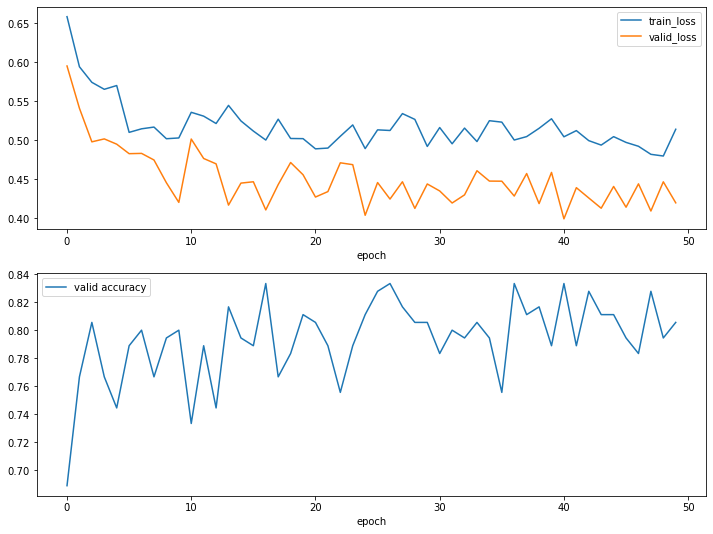

In [20]:
plot_training(train_losses, val_losses, val_accur)

In [21]:
model_eff = torch.load('../models/my_model_cnn_eff.pt').to(device)
                      
accur, f1_sc, cof_matrix, _ = count_metrics(test_dl, device, model_eff, loss_fn, [Count_F1_score(num_classes=2),
                                                                  Count_Accuracy(num_classes=2),
                                                                  Count_ConfusionMatrix(num_classes=2)])

  0%|          | 0/34 [00:00<?, ?it/s]

In [22]:
cof_matrix

tensor([[41,  7],
        [ 6, 46]])

In [23]:
print('test auc: ', accur)
print('f1 auc: ', f1_sc)

test auc:  0.8647059202194214
f1 auc:  0.8725490570068359


# efficientnet_b1

In [17]:
model_ef_1, optimizer = model_eff(models.efficientnet_b1(pretrained=True))

In [19]:
train_losses, val_losses, val_accur, val_f1 = fit(10, model_ef_1,
                                                      loss_fn,
                                                      optimizer,
                                                      train_dl,
                                                      valid_dl,
                                                      device,
                                                      'model_ef_1')

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5233787306894858


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.46354218274354936
valid accuracies:  0.8055556416511536
valid f1:  0.8033334612846375

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5702008533291518


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4808079811433951
valid accuracies:  0.7888889908790588
valid f1:  0.7838889360427856
epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5161920201964676


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4702495827029149
valid accuracies:  0.8000000715255737
valid f1:  0.8138889670372009
epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5351134369460245


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4590649127960205
valid accuracies:  0.8055556416511536
valid f1:  0.806111216545105
epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5306244047048191


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.45970745931069057
valid accuracies:  0.8055556416511536
valid f1:  0.8033334016799927
epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.542947723188748


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48621196039021014
valid accuracies:  0.7777778506278992
valid f1:  0.7827778458595276
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5284493236181637


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48090670791765056
valid accuracies:  0.8055556416511536
valid f1:  0.806111216545105
epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5063198216259479


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48620234057307243
valid accuracies:  0.7777778506278992
valid f1:  0.7638888955116272
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5107145981863142


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4491010936597983
valid accuracies:  0.8333333730697632
valid f1:  0.8283333778381348

 save model 

epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.513053644541651


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4912243545055389
valid accuracies:  0.8000000715255737
valid f1:  0.7927777767181396


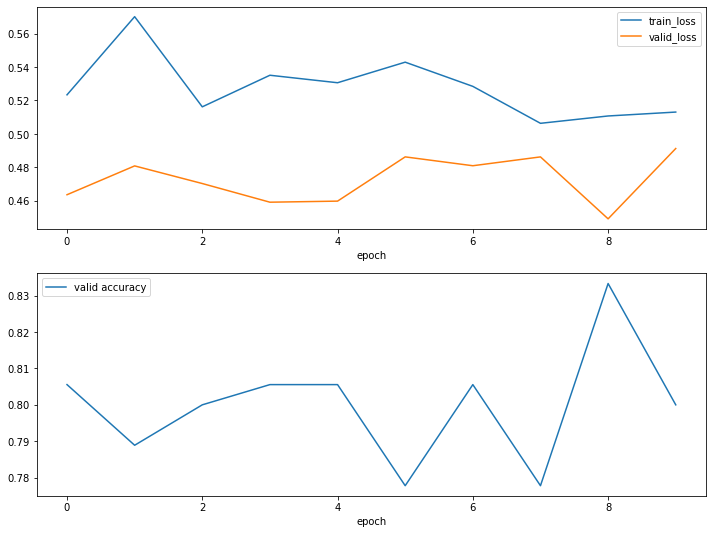

In [24]:
plot_training(train_losses, val_losses, val_accur)

In [23]:
testing_model('model_ef_1')

  0%|          | 0/34 [00:00<?, ?it/s]

test auc:  0.8245097994804382
test f1:  0.8529411554336548
ConfusionMatrix:
 tensor([[38, 10],
        [ 5, 47]])


# efficientnet_b2

In [26]:
model_test

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [28]:
model_ef_2, optimizer_2 = model_eff(models.efficientnet_b2(pretrained=True))

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6598147571086883


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6231557309627533
valid accuracies:  0.7333333492279053
valid f1:  0.7350000739097595

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.610863696411252


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5639679975807667
valid accuracies:  0.7722222805023193
valid f1:  0.7766667008399963

 save model 

epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5622085347771645


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5543064822753271
valid accuracies:  0.7388889789581299
valid f1:  0.7538889050483704
epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.572341678229471


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5086948434511821
valid accuracies:  0.8055556416511536
valid f1:  0.8038889169692993

 save model 

epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5412394280855855


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4986286217967669
valid accuracies:  0.7833333611488342
valid f1:  0.7950000762939453
epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5563786323492725


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5204552585879961
valid accuracies:  0.7388889789581299
valid f1:  0.726111114025116
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5298971316156288


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.49950034320354464
valid accuracies:  0.7944445013999939
valid f1:  0.7766667604446411
epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5286117820069194


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4980843757589658
valid accuracies:  0.8111111521720886
valid f1:  0.8094445466995239

 save model 

epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5523051720733444


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4894708330432574
valid accuracies:  0.8222222924232483
valid f1:  0.8166667222976685

 save model 

epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5388497085620959


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5255282990634441
valid accuracies:  0.7388889789581299
valid f1:  0.7538889050483704


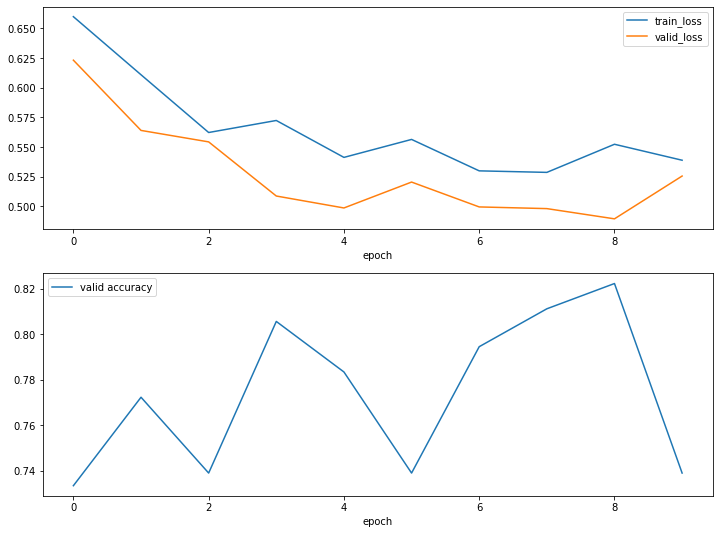

In [29]:
start_fit_model(model_ef_2, optimizer_2, 10, 'model_ef_2')

In [30]:
testing_model('model_ef_2')

  0%|          | 0/34 [00:00<?, ?it/s]

test auc:  0.8264706134796143
test f1:  0.8431373238563538
ConfusionMatrix:
 tensor([[36, 12],
        [ 2, 50]])


# efficientnet_b3

In [36]:
model_ef_3, optimizer_3 = model_eff(models.efficientnet_b3(pretrained=True))

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6798425885538261


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  4.182033061981201
valid accuracies:  0.6666666865348816
valid f1:  0.652222216129303

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6146217856556178


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.8202885913352171
valid accuracies:  0.7277778387069702
valid f1:  0.7211111783981323

 save model 

epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5777250877271096


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6356021324793498
valid accuracies:  0.7833333611488342
valid f1:  0.7688888907432556

 save model 

epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5590102853253484


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5601793234546979
valid accuracies:  0.7777778506278992
valid f1:  0.7599999904632568
epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.565006140122811


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5147489696741104
valid accuracies:  0.7722222805023193
valid f1:  0.7794445157051086
epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5400573909903567


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5731695120533308
valid accuracies:  0.7166666984558105
valid f1:  0.7088890075683594
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.538079590909183


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5078330509364605
valid accuracies:  0.8333333730697632
valid f1:  0.8444444537162781

 save model 

epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5513636780902743


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5367272861301899
valid accuracies:  0.7611111998558044
valid f1:  0.7494444847106934
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5303958357622226


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.503366187463204
valid accuracies:  0.8000000715255737
valid f1:  0.8127778768539429
epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5474881924067935


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5991886888941129
valid accuracies:  0.7666667103767395
valid f1:  0.7672222256660461


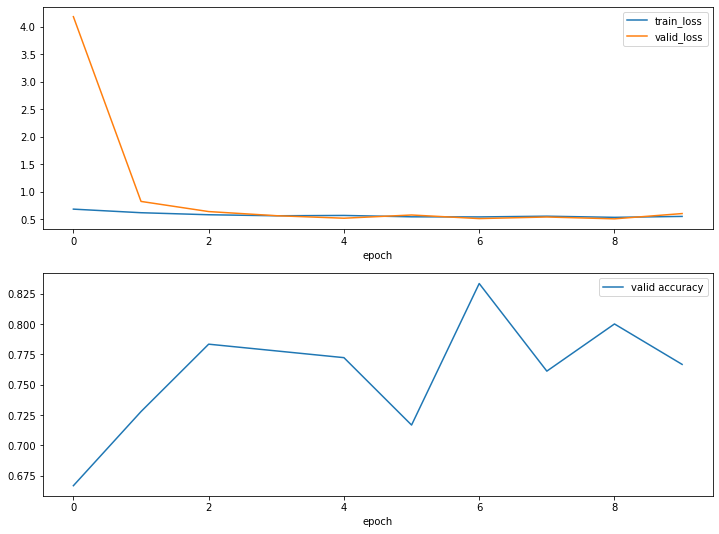

In [37]:
start_fit_model(model_ef_3, optimizer_3, 10, 'model_ef_3')

In [38]:
testing_model('model_ef_3')

  0%|          | 0/34 [00:00<?, ?it/s]

test auc:  0.8098039031028748
test f1:  0.8137255311012268
ConfusionMatrix:
 tensor([[38, 10],
        [ 9, 43]])


# efficientnet_b4

In [42]:
model_ef_4, optimizer_4 = model_eff(models.efficientnet_b4(pretrained=True))

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6723106959213813


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6596390465895335
valid accuracies:  0.7111111879348755
valid f1:  0.726111114025116

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6208147292335828


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6851957112550735
valid accuracies:  0.5944445133209229
valid f1:  0.56166672706604
epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5832361520578464


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.7393068780501684
valid accuracies:  0.6611111760139465
valid f1:  0.6505556702613831
epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5752228789652387


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6960512431959311
valid accuracies:  0.7666667103767395
valid f1:  0.7599999904632568

 save model 

epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5679061498492957


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6595328932007154
valid accuracies:  0.6444445252418518
valid f1:  0.6305556297302246
epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5593486003577709


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6788048153122266
valid accuracies:  0.7500000596046448
valid f1:  0.7505555748939514
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5730862418810526


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6335749104619026
valid accuracies:  0.7166666984558105
valid f1:  0.7283334136009216
epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.556131927544872


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.7291937654217084
valid accuracies:  0.6666666865348816
valid f1:  0.6572222709655762
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5573923499012987


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6660324896375338
valid accuracies:  0.7000000476837158
valid f1:  0.6805556416511536
epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5445347137128314


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6988131314516067
valid accuracies:  0.7500000596046448
valid f1:  0.7527778148651123


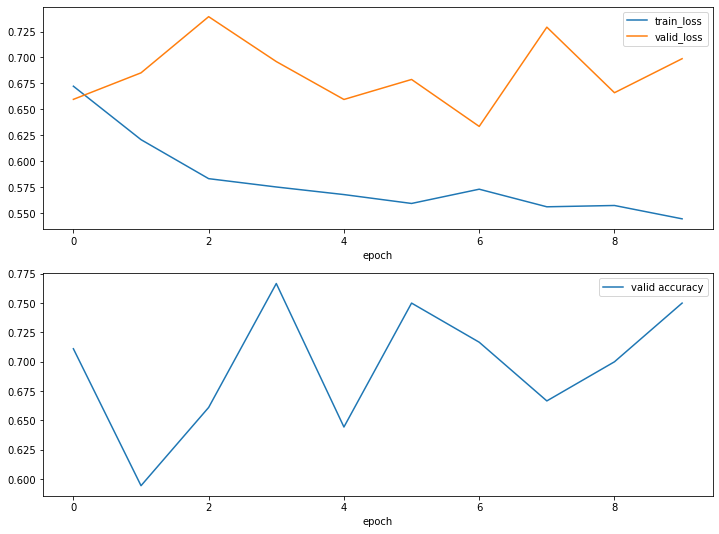

In [43]:
start_fit_model(model_ef_4, optimizer_4, 10, 'model_ef_4')

In [44]:
testing_model('model_ef_4')

  0%|          | 0/34 [00:00<?, ?it/s]

test auc:  0.7852941155433655
test f1:  0.7843137383460999
ConfusionMatrix:
 tensor([[35, 13],
        [ 9, 43]])


# efficientnet_b5

In [48]:
model_ef_5, optimizer_5 = model_eff(models.efficientnet_b5(pretrained=True))

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6395537979900837


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.6333861107627551
valid accuracies:  0.6611111760139465
valid f1:  0.6516667008399963

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5790221712862452


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5809317345420519
valid accuracies:  0.7444444894790649
valid f1:  0.7344444394111633

 save model 

epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5397475427016616


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5666897659500439
valid accuracies:  0.7277778387069702
valid f1:  0.7266666889190674
epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5578527559215823


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5594068432847659
valid accuracies:  0.7277778387069702
valid f1:  0.7261111736297607
epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5468259875041743


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5574314564466476
valid accuracies:  0.7666667103767395
valid f1:  0.7405555844306946

 save model 

epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5540271115799745


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5369145651658376
valid accuracies:  0.7500000596046448
valid f1:  0.7300000190734863
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5246350271006425


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5490591856340568
valid accuracies:  0.7388889789581299
valid f1:  0.7361111640930176
epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5357391808802883


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5280760392546654
valid accuracies:  0.7388889789581299
valid f1:  0.7361111640930176
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.528078923219194


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5324882124861081
valid accuracies:  0.7722222805023193
valid f1:  0.7572222948074341

 save model 

epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5459447510540485


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5295117512345314
valid accuracies:  0.7611111998558044
valid f1:  0.7622222900390625


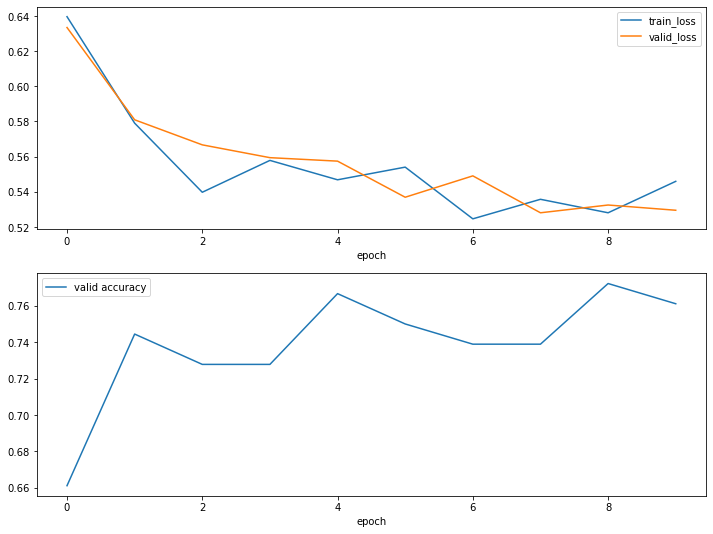

In [49]:
start_fit_model(model_ef_5, optimizer_5, 10, 'model_ef_5')

In [50]:
testing_model('model_ef_5')

  0%|          | 0/34 [00:00<?, ?it/s]

test auc:  0.7862744927406311
test f1:  0.7941176295280457
ConfusionMatrix:
 tensor([[41,  7],
        [14, 38]])


# DensNet121

In [16]:
def model_densnet(model):
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier = nn.Sequential(
                      nn.Linear(in_features=1024 , out_features=2, bias=True),                   
                      nn.Softmax(dim=1))
    model = model.to('cuda')
    optimizer = optim.Adam(model.parameters())
    
    return model, optimizer

In [17]:
model_densnet_121, optimizer_densnet_121, = model_densnet(models.densenet121(pretrained=True))

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.6058402576794227


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5548041671514511
valid accuracies:  0.7722222805023193
valid f1:  0.7622222900390625

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5798666949073473


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5563377733031909
valid accuracies:  0.7722222805023193
valid f1:  0.7666667103767395
epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.599968123063445


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5176621168851853
valid accuracies:  0.8500000238418579
valid f1:  0.8355556130409241

 save model 

epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5795912840714057


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5114478806654612
valid accuracies:  0.8500000238418579
valid f1:  0.8294444680213928
epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5810460206121206


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5305114428202311
valid accuracies:  0.7944445013999939
valid f1:  0.7838889360427856
epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5816895258923371


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5064702287316323
valid accuracies:  0.8500000238418579
valid f1:  0.8477778434753418
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5898727446794509


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5185550019145012
valid accuracies:  0.8277778625488281
valid f1:  0.8205556273460388
epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5642598456392686


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.514243105550607
valid accuracies:  0.8333333730697632
valid f1:  0.8122222423553467
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5785239814470212


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.49907361169656117
valid accuracies:  0.8500000238418579
valid f1:  0.8477778434753418
epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5824359827985366


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5151194075743357
valid accuracies:  0.7944445013999939
valid f1:  0.7916666865348816
epoch  10


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5774997553477684


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5157767901817958
valid accuracies:  0.8277778625488281
valid f1:  0.8183333277702332
epoch  11


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5666041139513254


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5022681290904681
valid accuracies:  0.8277778625488281
valid f1:  0.8255555629730225
epoch  12


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5692200525353353


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4995254288117091
valid accuracies:  0.8277778625488281
valid f1:  0.8133334517478943
epoch  13


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5625791610529025


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4902346099416415
valid accuracies:  0.8333333730697632
valid f1:  0.8266667127609253
epoch  14


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5712093720833461


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.49229543258746467
valid accuracies:  0.8611111640930176
valid f1:  0.8611111044883728

 save model 

epoch  15


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.582145091642936


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4946411435802778
valid accuracies:  0.8166667222976685
valid f1:  0.8205556869506836
epoch  16


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5689872602621714


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5121597806612651
valid accuracies:  0.8000000715255737
valid f1:  0.7933333516120911
epoch  17


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5656128590305646


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5057785585522652
valid accuracies:  0.8277778625488281
valid f1:  0.834444522857666
epoch  18


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5636541113257408


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4914664929111799
valid accuracies:  0.8111111521720886
valid f1:  0.8138889074325562
epoch  19


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5686430860310793


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.516568024456501
valid accuracies:  0.7833333611488342
valid f1:  0.7783333659172058
epoch  20


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5673232056200505


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48789511422316234
valid accuracies:  0.8444445133209229
valid f1:  0.8466667532920837
epoch  21


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5593391735106706


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48654259492953617
valid accuracies:  0.8388890027999878
valid f1:  0.8316667079925537
epoch  22


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5816444685061772


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5051917523145676
valid accuracies:  0.8111111521720886
valid f1:  0.8127778172492981
epoch  23


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5637416049838067


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4910860205690066
valid accuracies:  0.8222222924232483
valid f1:  0.82833331823349
epoch  24


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5567898582667112


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.47449490626653035
valid accuracies:  0.8555556535720825
valid f1:  0.8622222542762756
epoch  25


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5637466542422771


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4990888441602389
valid accuracies:  0.8277778625488281
valid f1:  0.8255555629730225
epoch  26


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5596851464360952


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.47700642943382265
valid accuracies:  0.8555556535720825
valid f1:  0.851111114025116
epoch  27


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5546922492484252


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5080656573176384
valid accuracies:  0.8222222924232483
valid f1:  0.8250000476837158
epoch  28


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5746114415427049


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48080126543839774
valid accuracies:  0.8444445133209229
valid f1:  0.8333333730697632
epoch  29


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5659133716175954


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4963191216190656
valid accuracies:  0.8166667222976685
valid f1:  0.8111111521720886
epoch  30


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5617179530362288


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48970186710357666
valid accuracies:  0.8277778625488281
valid f1:  0.8177778124809265
epoch  31


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5676418259739876


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4903474440177282
valid accuracies:  0.8277778625488281
valid f1:  0.8188889622688293
epoch  32


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.551384865368406


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4960482696692149
valid accuracies:  0.8222222924232483
valid f1:  0.81166672706604
epoch  33


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5586370376249155


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4767933780948321
valid accuracies:  0.8333333730697632
valid f1:  0.8411111831665039
epoch  34


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5545692180593809


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48298228085041045
valid accuracies:  0.8555556535720825
valid f1:  0.8611111044883728
epoch  35


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5552014321088791


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.472103292743365
valid accuracies:  0.8666667342185974
valid f1:  0.8505555987358093
epoch  36


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.563180968662103


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.484434142212073
valid accuracies:  0.8277778625488281
valid f1:  0.8277778625488281
epoch  37


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5607161284734805


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4747498999039332
valid accuracies:  0.8666667342185974
valid f1:  0.8522223234176636
epoch  38


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5608036950230598


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4908555865287781
valid accuracies:  0.8111111521720886
valid f1:  0.81166672706604
epoch  39


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5539161107192437


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.48700110415617626
valid accuracies:  0.8388890027999878
valid f1:  0.8338890075683594
epoch  40


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5525073657433192


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4761111781001091
valid accuracies:  0.8611111640930176
valid f1:  0.8477778434753418
epoch  41


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5443460964908202


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5002140760421753
valid accuracies:  0.8055556416511536
valid f1:  0.8155556321144104
epoch  42


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5574920913825433


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.47334879885117215
valid accuracies:  0.8500000238418579
valid f1:  0.853888988494873
epoch  43


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5460366732130448


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4863419463237127
valid accuracies:  0.8500000238418579
valid f1:  0.8388890027999878
epoch  44


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5492353683958451


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5048247029383978
valid accuracies:  0.8277778625488281
valid f1:  0.8272222876548767
epoch  45


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5490531224757433


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4923324977358182
valid accuracies:  0.8388890027999878
valid f1:  0.8500000238418579
epoch  46


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.570838650316


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4680472955107689
valid accuracies:  0.8666667342185974
valid f1:  0.8644444942474365

 save model 

epoch  47


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5424307644367218


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4790534391999245
valid accuracies:  0.8388890027999878
valid f1:  0.8255555629730225
epoch  48


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.567782611399889


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4749326209227244
valid accuracies:  0.8777778744697571
valid f1:  0.8700000047683716

 save model 

epoch  49


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5611754111945629


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.49112002601226173
valid accuracies:  0.8166667222976685
valid f1:  0.816111147403717


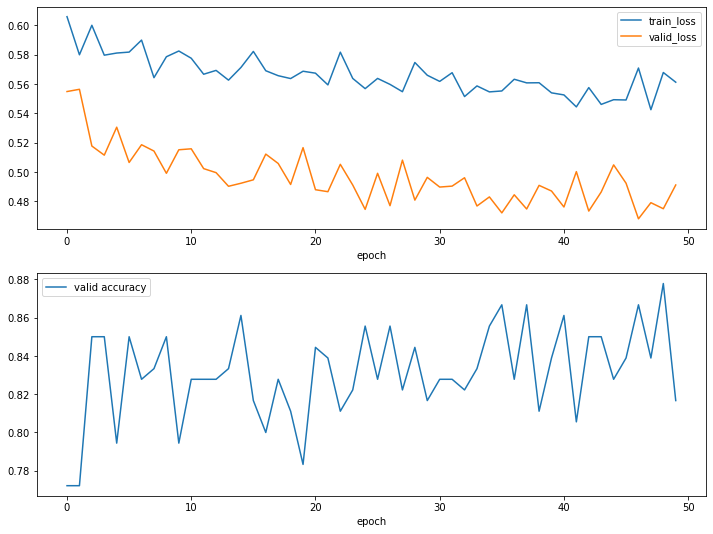

In [22]:
start_fit_model(model_densnet_121, optimizer_densnet_121, 50, 'model_densnet_121_softmax_50')

In [23]:
testing_model('model_densnet_121_softmax_50')

  0%|          | 0/34 [00:00<?, ?it/s]

test auc:  0.8735294342041016
test f1:  0.8823529481887817
ConfusionMatrix:
 tensor([[37, 11],
        [ 1, 51]])


In [17]:
 model = torch.load(f'../models/model_densnet_121.pt').to(device)

In [20]:
model(test_dl)

TypeError: conv2d() received an invalid combination of arguments - got (DataLoader, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mDataLoader[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mDataLoader[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


# DensNet161

In [26]:
model_densnet_161

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [28]:
model_densnet_161, optimizer_densnet_161, = model_densnet(models.densenet161(pretrained=True))

epoch  0


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5325663679589828


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.44070814761022725
valid accuracies:  0.7833333611488342
valid f1:  0.7944445013999939

 save model 

epoch  1


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5294977912368873


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.428056009610494
valid accuracies:  0.8444445133209229
valid f1:  0.8372222781181335

 save model 

epoch  2


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5216207502409815


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4308744470278422
valid accuracies:  0.8222222924232483
valid f1:  0.8172222375869751
epoch  3


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.502579137062033


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.38335042757292587
valid accuracies:  0.8388890027999878
valid f1:  0.8233333826065063
epoch  4


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5335013345815242


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.38965598940849305
valid accuracies:  0.8666667342185974
valid f1:  0.8611111044883728

 save model 

epoch  5


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5191793312318623


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.38895721739778916
valid accuracies:  0.8444445133209229
valid f1:  0.8372223377227783
epoch  6


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5360566909424961


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.41283316823343436
valid accuracies:  0.8333333730697632
valid f1:  0.8222222328186035
epoch  7


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5679857869322101


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4214537174751361
valid accuracies:  0.8277778625488281
valid f1:  0.7977778315544128
epoch  8


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5154286031921704


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.39001381595929463
valid accuracies:  0.8444445133209229
valid f1:  0.8322222828865051
epoch  9


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5354945786297322


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3872198143353065
valid accuracies:  0.8611111640930176
valid f1:  0.8472223281860352
epoch  10


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.48676154147833584


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.40395015229781467
valid accuracies:  0.8500000238418579
valid f1:  0.8516666889190674
epoch  11


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4952436214312911


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.5087755795568227
valid accuracies:  0.7166666984558105
valid f1:  0.694444477558136
epoch  12


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4850398974803587


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4307112650635342
valid accuracies:  0.7666667103767395
valid f1:  0.7611111998558044
epoch  13


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5017424020295341


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4080891953781247
valid accuracies:  0.8000000715255737
valid f1:  0.7755556106567383
epoch  14


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5168802775753041


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3823524059727788
valid accuracies:  0.8444445133209229
valid f1:  0.8294444680213928
epoch  15


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5273396947421134


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3972080687060952
valid accuracies:  0.8277778625488281
valid f1:  0.8255555629730225
epoch  16


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5055167599270741


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.374341725744307
valid accuracies:  0.8222222924232483
valid f1:  0.8227778673171997
epoch  17


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.513400770444423


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4142950139939785
valid accuracies:  0.8222222924232483
valid f1:  0.8100000619888306
epoch  18


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.48116574712718524


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3772492233663797
valid accuracies:  0.8666667342185974
valid f1:  0.8738889694213867
epoch  19


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4926868294676145


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3870541037991643
valid accuracies:  0.8333333730697632
valid f1:  0.8250000476837158
epoch  20


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.47821486679216224


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3959929334620635
valid accuracies:  0.8333333730697632
valid f1:  0.8383334279060364
epoch  21


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.494468452129513


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3681814339632789
valid accuracies:  0.8444445133209229
valid f1:  0.8244444727897644
epoch  22


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4738272038598855


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4308585686609149
valid accuracies:  0.7722222805023193
valid f1:  0.7583333849906921
epoch  23


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.488213513387988


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3760006928816438
valid accuracies:  0.8444445133209229
valid f1:  0.8411111831665039
epoch  24


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.48977562682703135


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3784021814664205
valid accuracies:  0.8444445133209229
valid f1:  0.8416666984558105
epoch  25


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4970179655589163


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4301501989364624
valid accuracies:  0.8000000715255737
valid f1:  0.795555591583252
epoch  26


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.49637824824700755


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3900943155710896
valid accuracies:  0.8722223043441772
valid f1:  0.8677778244018555

 save model 

epoch  27


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4944763698304693


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3897866291925311
valid accuracies:  0.8166667222976685
valid f1:  0.8372223377227783
epoch  28


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.49557287863766153


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3928437246630589
valid accuracies:  0.8444445133209229
valid f1:  0.8444444537162781
epoch  29


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4933356288510064


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3891659310087562
valid accuracies:  0.8500000238418579
valid f1:  0.8477778434753418
epoch  30


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4876347123490026


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3643910836428404
valid accuracies:  0.8555556535720825
valid f1:  0.8627778887748718
epoch  31


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5165646462701261


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3722726912237704
valid accuracies:  0.8277778625488281
valid f1:  0.837777853012085
epoch  32


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5016487792134285


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.42106936958928903
valid accuracies:  0.8166667222976685
valid f1:  0.8316667079925537
epoch  33


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4846148555787901


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.410457561040918
valid accuracies:  0.7888889908790588
valid f1:  0.8038888573646545
epoch  34


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5143947467518349


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4022389454456667
valid accuracies:  0.8166667222976685
valid f1:  0.8244444727897644
epoch  35


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.504824593073378


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.37648860849440097
valid accuracies:  0.8166667222976685
valid f1:  0.8294444680213928
epoch  36


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4928168326305846


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.36973310162623724
valid accuracies:  0.8166667222976685
valid f1:  0.807222306728363
epoch  37


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.47013545765851933


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3922833043461045
valid accuracies:  0.8111111521720886
valid f1:  0.8133334517478943
epoch  38


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.48842914233294626


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.39202770243088403
valid accuracies:  0.8277778625488281
valid f1:  0.8316667079925537
epoch  39


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.5002485274026791


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3727306923518578
valid accuracies:  0.8666667342185974
valid f1:  0.8555556535720825
epoch  40


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4963531430189808


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.4133781831090649
valid accuracies:  0.7944445013999939
valid f1:  0.8038888573646545
epoch  41


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4709737923461944


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3740157963087161
valid accuracies:  0.8777778744697571
valid f1:  0.8755555748939514

 save model 

epoch  42


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4984876501529167


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.37656921266267696
valid accuracies:  0.8388890027999878
valid f1:  0.8427778482437134
epoch  43


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4653293875666956


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.39837345654765766
valid accuracies:  0.8444445133209229
valid f1:  0.8411111831665039
epoch  44


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.48635360607877376


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3502997573154668
valid accuracies:  0.8444445133209229
valid f1:  0.842222273349762
epoch  45


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4761132963001728


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3509365333865086
valid accuracies:  0.8611111640930176
valid f1:  0.8477778434753418
epoch  46


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.484618634202828


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.37944412299742303
valid accuracies:  0.8333333730697632
valid f1:  0.8361111283302307
epoch  47


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4729139226178328


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.35572489301363625
valid accuracies:  0.8722223043441772
valid f1:  0.8705556392669678
epoch  48


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.48376552714034915


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.37090727866937717
valid accuracies:  0.8277778625488281
valid f1:  0.8288889527320862
epoch  49


  0%|          | 0/240 [00:00<?, ?it/s]

train_loss:  0.4917969519893328


  0%|          | 0/60 [00:00<?, ?it/s]

valid loss:  0.3566722495481372
valid accuracies:  0.8444445133209229
valid f1:  0.8555556535720825


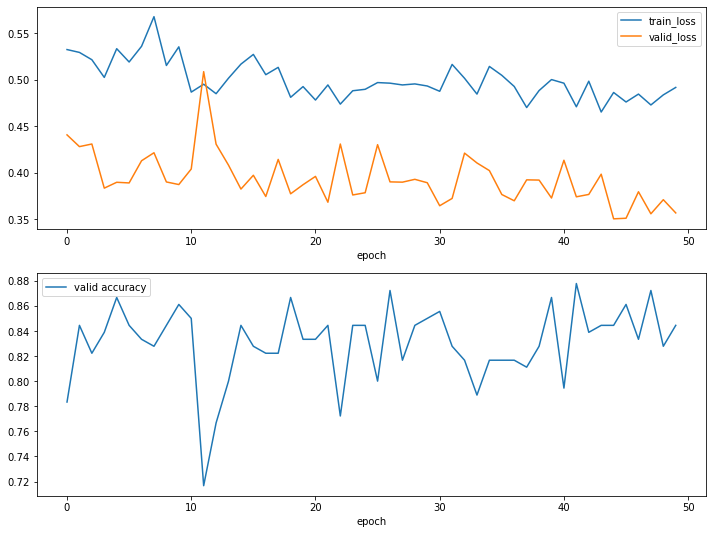

In [31]:
start_fit_model(model_densnet_161, optimizer_densnet_161, 50, 'model_densnet_161_50')

In [32]:
testing_model('model_densnet_161_50')

  0%|          | 0/34 [00:00<?, ?it/s]

test auc:  0.8254901766777039
test f1:  0.8431373238563538
ConfusionMatrix:
 tensor([[34, 14],
        [ 0, 52]])
